In [5]:
import glob
import os
import numpy as np
import yaml
import astropy.units as u
from astropy.io import ascii
import os
import matplotlib.pyplot as plt
import json
import subprocess
import hiplot as hip
dir = '25feb21' # enter date string here

## Read and plot data

In [6]:
os.system('cat /mnt/data/dsa110/T2/'+dir+'/*.cand > tmp.dat')
#snr,it,itime,mjds,ibox,idm,dm,memb,ibeam = np.loadtxt('tmp.dat').transpose()
snr,it,itime,mjds,ibox,idm,dm,ibeam,cl,cntc,cntb,trigger = np.loadtxt('tmp.dat').transpose()
os.system('echo snr,if,itime,mjds,ibox,idm,dm,ibeam,cl,cntc,cntb,trigger > /mnt/data/dsa110/T2/' + dir + '/cluster_output.csv')
os.system('cat /mnt/data/dsa110/T2/' + dir + '/cluster_output*cand | tr " " "," >> /mnt/data/dsa110/T2/' + dir + '/cluster_output.csv')

0

/mnt/data/dsa110/T3/scripts
           snr         if    itime          mjds  ibox  idm        dm  ibeam  \
19     9.37676    2477379    36163  59270.752767    16   11   65.9831     92   
297    8.13892   15154490   232762  59270.755153    18   36  193.6750    115   
656    7.76151   27303218   421170  59270.757440    16   44  234.7940    137   
736    7.81830   31792551   490919  59270.758286    19   34  183.4200    145   
2583   8.94794  122209242  1909722  59270.881376    13    8   50.7100     12   
...        ...        ...      ...           ...   ...  ...       ...    ...   
26230  8.48980  197391290  3077050  59271.164107     2    9   55.8004    127   
26245  8.53089  197927852  3085228  59271.164206     2   15   86.3577    130   
26362  8.71635  145224852  2258068  59271.199182     2   11   65.9831    191   
26429  8.60765   20299212   314828  59271.220600    11    8   50.7100     91   
26875  7.81328   63037593   983193  59271.228711    10   15   86.3577     30   

        cl 

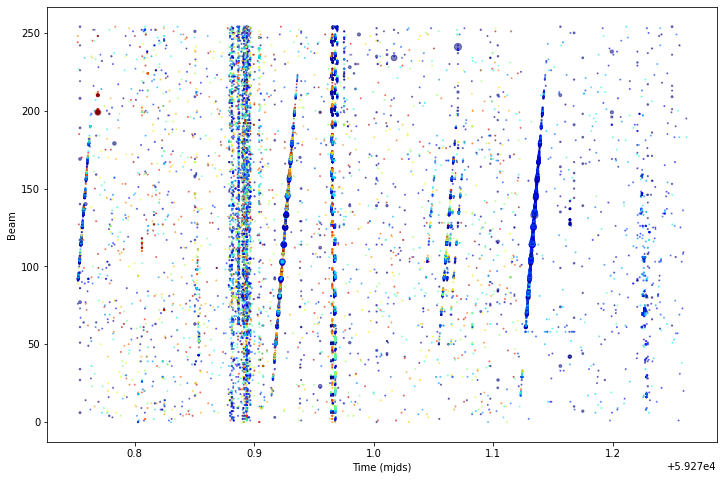

In [10]:
import pandas as pd
#metadata = np.load(dir+'_cat.npz')['metadata']
%cd /mnt/data/dsa110/T3/scripts
cmd = ['python', 'gen_T3_inspect.py', dir]
p = subprocess.Popen(cmd, stdout=subprocess.PIPE)
p.wait()

metadata = pd.read_csv('/mnt/data/dsa110/T2/'+dir+'/cluster_output.csv')


plt.figure(figsize=(12,8))
plt.xlabel('Time (mjds)')
plt.ylabel('Beam')
s = metadata['snr']**3.5
s /= np.min(s)
dmc = metadata['dm']/np.max(metadata['dm'])
x0 = 59271
x1 = x0 + 0.5 # set xlim in day
x2 = x1+1. # set xlim in day
#plt.xlim(x1,x2)
plt.scatter(metadata['mjds'],metadata['ibeam'],s=s,alpha=0.5,cmap='jet',c=dmc)


# need to read in json from each corr node
fls = glob.glob('/mnt/data/dsa110/T3/corr01/'+dir+'/fl*.json')
for fl in fls:
    f = open(fl)
    d = json.load(f)  
    snum = int(list(d.keys())[0])
    snum2 = 16*(snum-477)
    val = list(d.values())[0]
    plt.plot([float(snum)*0.001048576/3600.],[float(val['ibeam'])],'s',markersize=20.,markeredgecolor='black',markerfacecolor='none')


#for mm in metadata:
i = 0
for i, mm in metadata.iterrows():
    if float(mm['mjds']) > x1:
        if float(mm['mjds']) < x2:
            if mm['trigger']==1:
                plt.plot([float(mm['mjds'])],[float(mm['ibeam'])],'s',markersize=20.,markeredgecolor='black',markerfacecolor='none')
                plt.text(float(mm['mjds']),float(mm['ibeam']),str(mm['itime']),fontsize=10)
                #print(i,mm[5],mm[0],float(mm['mjds']),mm[2],mm[3],mm[4],mm[6])
                #print(mm[6],i)
                i += 1

# print all triggers and the files? 
print(metadata[metadata['trigger'] == 1])
print('/mnt/data/dsa110/T2/'+dir+'/fl_output.dat')

In [52]:
# compare old and new data file 
# import pandas as pd
# f = pd.read_csv('/mnt/data/dsa110/T2/22feb21/cluster_output.csv')

# print(f)

# f2=np.load('11feb21_cat.npz')['metadata']
# print(f2)

# hiplot high-dimensional visualization of T2 output

## To view it, tunnel to port 5007 on dsa-storage and load csv file from hiplot web server.

## Features
* Displays "parallel" style plot with lines connecting a given candidate (row) from T2.
* Drag on an axis to select any subset of full sample.
* Can use "exclude" to reject RFI time windows.
* Can right click on axis to set it as x or y axis on 2d plot.
* Mouse over the table to highlight single values in parallel or 2d plot.

In [12]:
tab = ascii.read('/home/user/data/T2/'+dir+'/cluster_output.csv',
                 names=['snr', 'if', 'itime', 'mjds', 'ibox', 'idm', 'dm', 'ibeam', 'cl', 'cntc', 'cntb' ,'trigger'])

tab = tab[['mjds', 'itime', 'dm', 'ibeam', 'ibox', 'snr', 'trigger']]
hip.Experiment.from_dataframe(tab.to_pandas()).display()

<IPython.core.display.Javascript object>

## Now run through baseband or filterbank processing for any interesting candidates

In [4]:
# 1-to-1 mapping indexed by spectrum number (a.k.a. itime)
flfile = '/home/user/data/T2/'+dir+'/fl_output.dat'
trfile = '/home/user/data/T2/'+dir+'/trigger_output.csv'

In [ ]:
# This copies the latest bf weights and the data files
cmd = ['./cp_weights_corr22.bash']
p = subprocess.Popen(cmd, stdout=subprocess.PIPE)
for line in p.stdout:
    print(line)
p.wait()
os.system('./cp_corr22.bash '+metadata[2][5]) # edit first index to match line number above

In [ ]:
# This forms the coherent beam
os.system('./run_bf_corr22.bash '+metadata[2][4])

In [ ]:
# This copies the data across
os.system('cd ~/data; scp ubuntu@corr22.sas.pvt:./data/spliced.fil .')

### Alternatively, you can copy over single filterbank file, if heimdall saved it (separate trigger algorithm)

In [3]:
os.system('cd ~/data;scp /mnt/data/dsa110/T1/corr20/02feb21/candidate_8.89597_224.499_1_3727915_244.fil ./')

0

In [1]:
# The rest is up to you! You can use sigpyproc to plot up stuff
#filename = 'spliced.fil'
filename = 'candidate_8.89597_224.499_1_3727915_244.fil'
from sigpyproc.Readers import FilReader
%cd /home/user/data
f = FilReader(filename)
f.header

/mnt/data/dsa110


{'source_name': 'DSATEST',
 'machine_id': 1,
 'telescope_id': 82,
 'data_type': 1,
 'fch1': 1529.8779296875,
 'foff': -0.244140625,
 'nchans': 1024,
 'nbits': 8,
 'tstart': 55000.0,
 'tsamp': 0.0010485760867595673,
 'nifs': 1,
 'hdrlen': 217,
 'filelen': 270553,
 'nbytes': 270336,
 'nsamples': 264,
 'filename': 'candidate_8.89597_224.499_1_3727915_244.fil',
 'basename': 'candidate_8.89597_224.499_1_3727915_244',
 'extension': '.fil',
 'bandwidth': 250.0,
 'ftop': 1530.0,
 'fbottom': 1280.0,
 'fcenter': 1405.0,
 'tobs': 0.27682408690452576,
 'src_raj': 0,
 'src_dej': 0,
 'ra': '00:00:00.0000',
 'dec': '00:00:00.0000',
 'ra_rad': 0.0,
 'dec_rad': 0.0,
 'ra_deg': 0.0,
 'dec_deg': 0.0,
 'obs_date': '17/06/2009',
 'obs_time': '00:00:00.00000',
 'dtype': '<u1'}

In [5]:
ts = f.dedisperse(343.6)
fts = ts.applyBoxcar(256)
x = np.arange(len(fts))*f.header['tsamp']*1e3
plt.figure(figsize=(12,4.))
plt.plot(x,fts)
plt.xlabel('Time (ms)')
plt.ylabel('power')
#plt.xlim(400.,800.)

AttributeError: 'OutStream' object has no attribute '_master_pid'

In [ ]:
#dnam = f.downsample(tfactor=32,ffactor=16,filename=filename)
#d = FilReader(dnam)
da = f.readBlock(0,f.header['nsamples'])

In [ ]:
plt.figure(figsize=(10,7))
mnspec = da.mean(axis=1)
for i in range(da.shape[1]):
    da[:,i] -= mnspec
da = np.reshape(da,(int(da.shape[0]/4),4,da.shape[1])).mean(axis=1)
plt.imshow(da,origin='lower',aspect='auto',cmap='coolwarm')#,vmin=-2.*np.std(da),vmax=2.*np.std(da))

In [1]:
ts.shape

NameError: name 'ts' is not defined